# Benchmark

In [1]:
import sys
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'
from pulp import *

from pathlib import Path
import sys
#path_root = Path(/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/uc_annealing.py).parents[2]
sys.path.append('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing')

from uc_annealing import UC_Annealing
from util.utils import calculate_relative_error, plot_error, plot_comparison

In [1]:
import timeit
from pulp import *

def classical_implementation(n_generators, n_hours, E, C, D):
    # Create a MILP problem
    prob = LpProblem("Unit_Commitment_Problem", LpMinimize)
    # Decision variables
    x = LpVariable.dicts("x", [(n, t) for n in range(n_generators) for t in range(n_hours)], cat="Binary")
    # Objective function
    prob += lpSum([C[n * n_hours + t] * x[n, t] for n in range(n_generators) for t in range(n_hours)])
    # Constraint function
    prob += lpSum([E[n * n_hours + t] * x[n, t] for n in range(n_generators) for t in range(n_hours)]) >= D

    # Solve the problem
    def solve_problem():
        prob.solve()

    # Measure the execution time
    execution_time = timeit.timeit(solve_problem, number=1)

    # Check the solution status
    if LpStatus[prob.status] == 'Optimal':
        # Retrieve the optimal solution
        solution = {(n, t): value(x[n, t]) for n in range(n_generators) for t in range(n_hours)}
        total_cost = value(prob.objective)
        return solution, total_cost, execution_time
    else:
        print("No feasible solution found.")

Define the variables

In [11]:
n_generators = np.arange(3, 61, 3)
n_hours = np.arange(6, 121, 6)
demand = np.arange(10, 201, 10)
C = np.random.randint(1, 11, size= 5000)     # cost of power plants at different hours
E = np.random.randint(1, 11, size=5000)  
problem = UC_Annealing(50, 100, C, E, 300)

Benchmark computational time and relative error

In [12]:
qpu_time = {}
cpu_time = {}
error = {}

for i in range(len(n_generators)):

    size = n_hours[i] * n_generators[i]
    C = np.random.randint(1, 11, size= size)     # cost of power plants at different hours
    E = np.random.randint(1, 11, size=size)     # efficiency of power plants at different times
    D = demand[i] # demand for a specific time period

    qpu_problem = UC_Annealing(n_generators[i], n_hours[i], C, E, D)
    qpu_sample = qpu_problem.sample

    qpu_time[size] = qpu_problem.qpu_access_time / 1000000
    filtered_keys = [key for key, value in qpu_sample.items() if value == 1]
    completed_list = [item + '0' if len(item) == 2 else item for item in filtered_keys]
    qpu_solution = [(int(item.split('_')[0][1:]), int(item.split('_')[1])) for item in completed_list]

    solution, cost, time = classical_implementation(n_generators[i], n_hours[i], E, C, D)
    cpu_solution = [(n, t) for (n, t), value in solution.items() if value == 1.0]

    cpu_time[size] = time


    if set(cpu_solution) == set(qpu_solution):
        print("Quantum and classical solution coincide")
        error[size] = 0
    else:
        error[size] = calculate_relative_error(cpu_solution, qpu_solution, size)
        print("Quantum and classical solutions do not coincide")
        print('qpu solution ', qpu_solution)
        print('cpu solution', cpu_solution)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/d08dadb1e9634dbe8570cd93207ea377-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/d08dadb1e9634dbe8570cd93207ea377-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 79 RHS
At line 81 BOUNDS
At line 100 ENDATA
Problem MODEL has 1 rows, 18 columns and 18 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5 - 0.00 seconds
Cgl0004I processed model has 1 rows, 18 columns (18 integer (18 of which binary)) and 18 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5
Cbc0038I 

# Plot relative error graph

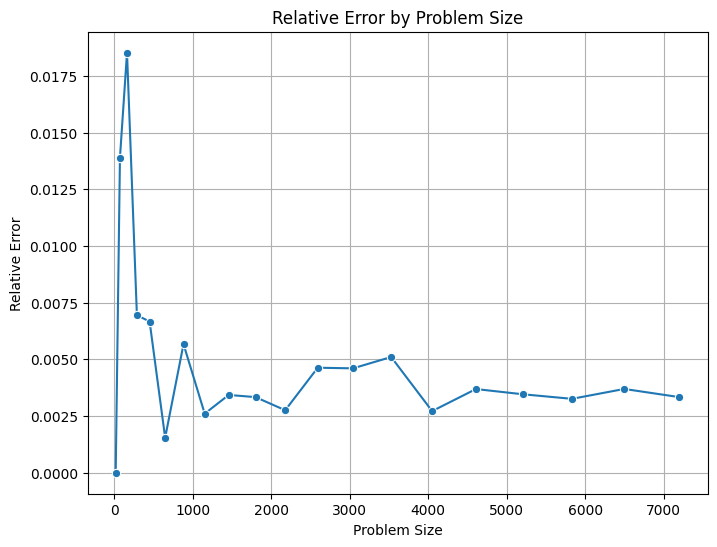

In [14]:
plot_error(error)

**Conclusion 1:**  the performance tends to improve with larger problem sizes.


**Conclusion 2:** The decreasing error trend suggests that the quantum annealing approach is providing some advantage over classical algorithms for larger problem sizes.

**Conclusion 3:** The presence of a relatively constant error at 0.004 could be due to 
- Imperfections in the quantum hardware
- Noise and decoherence effects
- Limitations of the quantum annealing techniques

# Plot computational time

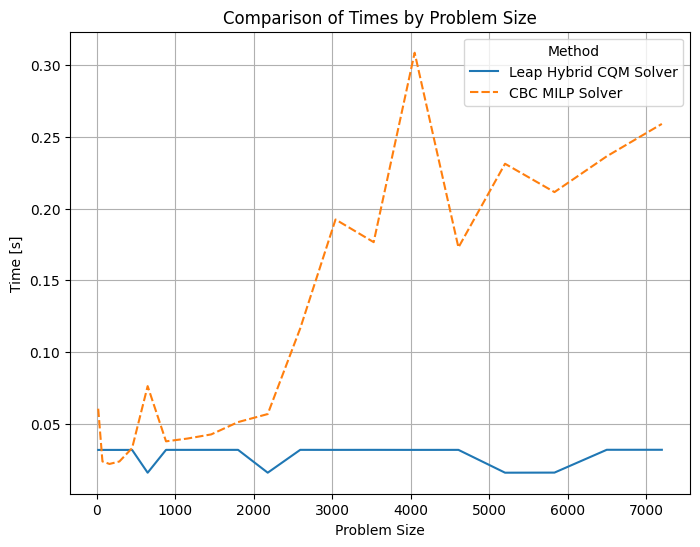

In [27]:
plot_comparison(qpu_time, cpu_time)

**Conclusion 1:** D-Wave limits the annealing time.

**Conclusion 2:** The computational resources required to solve the problem typically increase for classical algorithms.